## Import Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, ConfusionMatrixDisplay
import re
import string
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
# Ignore FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

## Read csv files

In [ ]:
d = pd.read_csv('train.csv',encoding='latin1');
f = pd.read_csv('test.csv',encoding='latin1');
df = pd.concat([d,f])

## Explore dataset

In [ ]:

df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797.0,27400.0,105.0
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0


                   Population -2020  Land Area (Km²)  Density (P/Km²)  \
Population -2020           1.000000         0.453869        -0.017294   
Land Area (Km²)            0.453869         1.000000        -0.054035   
Density (P/Km²)           -0.017294        -0.054035         1.000000   
sentiment_encoded         -0.000778         0.000924        -0.005087   

                   sentiment_encoded  
Population -2020           -0.000778  
Land Area (Km²)             0.000924  
Density (P/Km²)            -0.005087  
sentiment_encoded           1.000000  


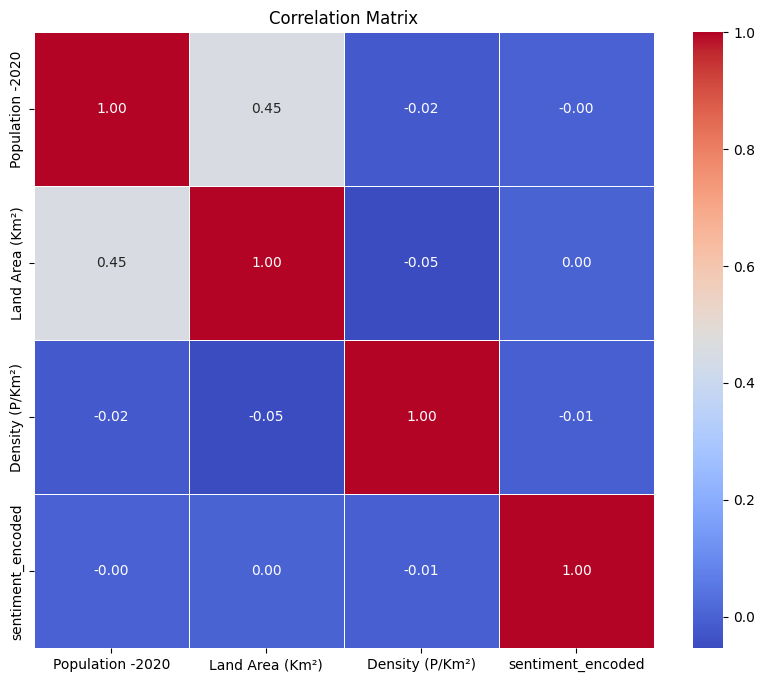

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

df_encoded = df.copy()

label_encoder = LabelEncoder()
df_encoded['sentiment_encoded'] = label_encoder.fit_transform(df_encoded['sentiment'])

numeric_columns_with_sentiment = df_encoded.select_dtypes(include=['float64', 'int64'])
correlation_matrix_with_sentiment = numeric_columns_with_sentiment.corr()

print(correlation_matrix_with_sentiment)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_with_sentiment, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


As we can,there is not significant relation between target feature and rest features like population,land area,density.So we will drop them

## Convert Data

In [ ]:
df.dropna(inplace=True)

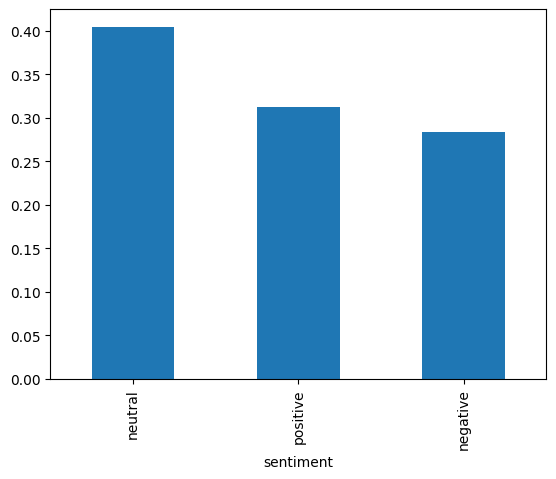

In [ ]:
df['sentiment'].value_counts(normalize=True).plot(kind='bar');

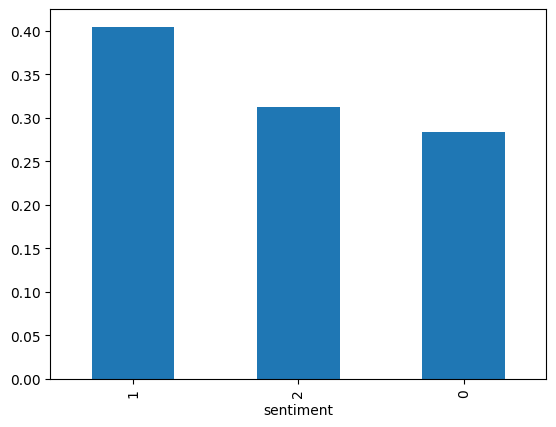

In [ ]:
# Converting  sentiment column to categorical variable
df['sentiment'] = df['sentiment'].astype('category').cat.codes
df['sentiment'].value_counts(normalize=True).plot(kind='bar');

In [ ]:
# Converting  Time of Tweet and Country column to categorical variable
df['Time of Tweet'] = df['Time of Tweet'].astype('category').cat.codes
df['Country'] = df['Country'].astype('category').cat.codes


# converting  Age of User to integer
df['Age of User']=df['Age of User'].replace({'0-20':18,'21-30':25,'31-45':38,'46-60':53,'60-70':65,'70-100':80})

## Drop unuseful data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27480 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27480 non-null  int8   
 4   Time of Tweet     27480 non-null  int8   
 5   Age of User       27480 non-null  int64  
 6   Country           27480 non-null  int16  
 7   Population -2020  27480 non-null  float64
 8   Land Area (Km²)   27480 non-null  float64
 9   Density (P/Km²)   27480 non-null  float64
dtypes: float64(3), int16(1), int64(1), int8(2), object(3)
memory usage: 1.8+ MB


In [ ]:
df.drop(columns=['textID','Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)'])

,text,selected_text,sentiment
0,"I`d have responded, if I were going","I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,0
2,my boss is bullying me...,bullying me,0
3,what interview! leave me alone,leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",0
...,...,...,...
27476,wish we could come see u on Denver husband l...,d lost,0
27477,I`ve wondered about rake to. The client has ...,", don`t force",0
27478,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,2
27479,But it was worth it ****.,But it was worth it ****.,2


## Creat a function to process text

In [ ]:
def wp(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
df['selected_text'] = df["selected_text"].apply(wp)

## Split data

In [ ]:
X=df['selected_text']
y= df['sentiment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21984,)
(5496,)
(21984,)
(5496,)


## Convert text to vectors

In [ ]:
vectorization = TfidfVectorizer()
XV_train = vectorization.fit_transform(X_train)
XV_test = vectorization.transform(X_test)

## Logistic regression

In [ ]:
lr = LogisticRegression(n_jobs=-1)
lr.fit(XV_train,y_train)

LogisticRegression(n_jobs=-1)

In [ ]:
pred_lr=lr.predict(XV_test)

In [ ]:
#accuracy score
score_lr = accuracy_score(y_test, pred_lr)
score_lr

0.8309679767103348

In [ ]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1572
           1       0.79      0.88      0.84      2236
           2       0.91      0.81      0.85      1688

    accuracy                           0.83      5496
   macro avg       0.84      0.82      0.83      5496
weighted avg       0.84      0.83      0.83      5496



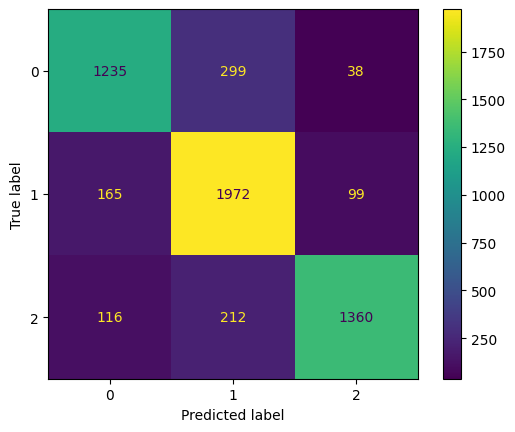

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, pred_lr);

## Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(XV_train, y_train)

RandomForestClassifier(random_state=0)

In [ ]:
pred_rfc = rfc.predict(XV_test)

In [ ]:
score_rfc = rfc.score(XV_test, y_test)
score_rfc

0.8138646288209607

In [ ]:
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.79      0.76      0.77      1572
           1       0.77      0.90      0.83      2236
           2       0.92      0.76      0.83      1688

    accuracy                           0.81      5496
   macro avg       0.83      0.80      0.81      5496
weighted avg       0.82      0.81      0.81      5496



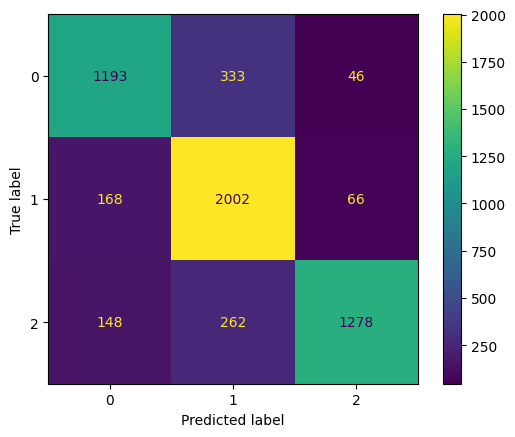

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, pred_rfc);

## Best model in accuracy

In [ ]:
print(f'Logistic regression {score_lr}\nRandom Forest Classifier {score_rfc}')

Logistic regression 0.8309679767103348
Random Forest Classifier 0.8138646288209607


# Hyper Parameter Tunning using Grid Search

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessin

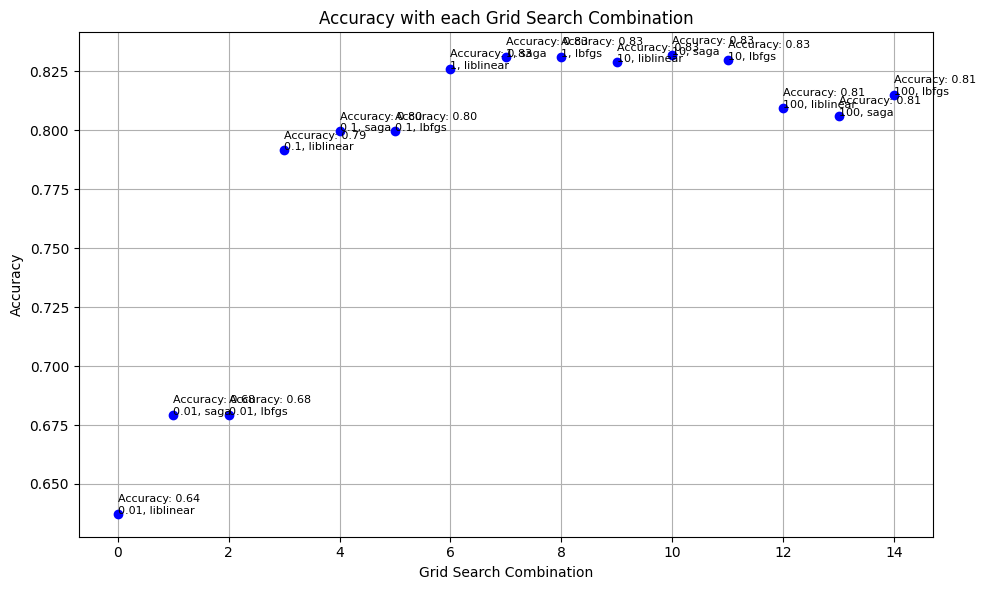

Max accuracy: 0.8316957787481805
Parameter with the maximum accuracy: C=10, solver=saga


In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Define parameter grid
# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
#     'solver': ['liblinear', 'saga', 'lbfgs']  # Solver types
# }

# # Initialize Logistic Regression model
# lr = LogisticRegression(random_state=0)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')

# # Fit the model
# grid_search.fit(XV_train, y_train)

# # Print the best parameters and accuracy
# print(f"Best parameters for Logistic Regression: {grid_search.best_params_}")
# print(f"Best accuracy for Logistic Regression: {grid_search.best_score_}")

import matplotlib.pyplot as plt
import numpy as np

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'saga', 'lbfgs']  # Solver types
}

lr = LogisticRegression(random_state=0)

accuracies = []

# Perform GridSearchCV
for params in param_grid['C']:
    for solver in param_grid['solver']:
        lr.set_params(C=params, solver=solver)
        lr.fit(XV_train, y_train)
        acc = lr.score(XV_test, y_test)
        accuracies.append(acc)

accuracies = np.array(accuracies)

# Create a scatter plot
plt.figure(figsize=(10, 6))
for i, acc in enumerate(accuracies):
    plt.plot(i, acc, 'bo')
    plt.text(i, acc, f"Accuracy: {acc:.2f}\n{param_grid['C'][i // 3]}, {param_grid['solver'][i % 3]}", fontsize=8)

plt.xlabel('Grid Search Combination')
plt.ylabel('Accuracy')
plt.title('Accuracy with each Grid Search Combination')

plt.grid(True)
plt.tight_layout()
plt.show()

max_acc_index = np.argmax(accuracies)
max_acc_lr=accuracies[max_acc_index]
print(f"Max accuracy:",max_acc_lr)
print(f"Parameter with the maximum accuracy: C={param_grid['C'][max_acc_index // 3]}, solver={param_grid['solver'][max_acc_index % 3]}")

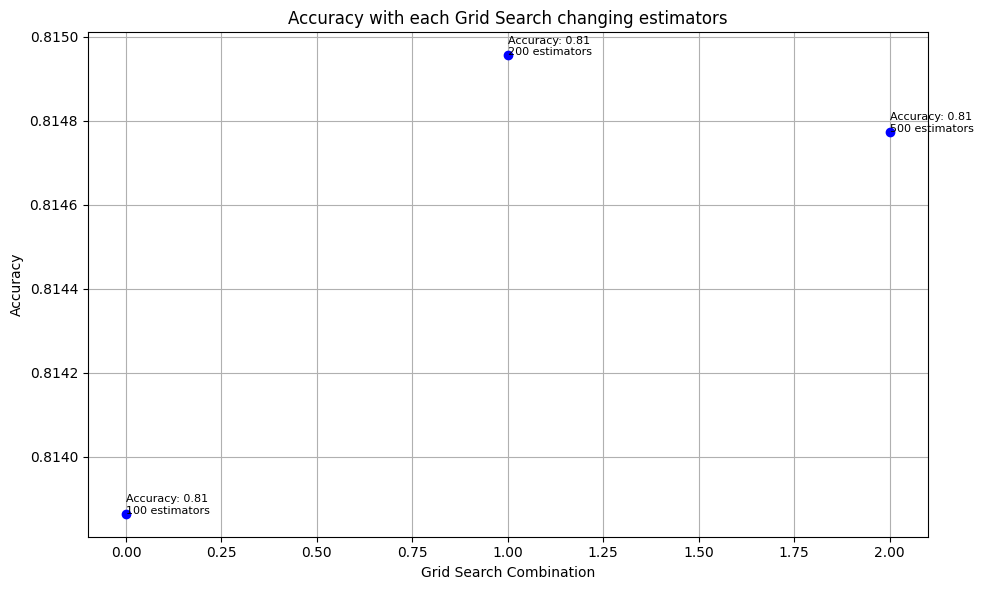

The max_accuracy is 0.8149563318777293


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

param_grid = {
    'n_estimators': [100, 200, 500],
    # 'max_depth': [5, 10, 15]
}

rfc = RandomForestClassifier(random_state=0)

accuracies_rfc = []

for n_estimators in param_grid['n_estimators']:
    # for max_depth in param_grid['max_depth']:
        rfc.set_params(n_estimators=n_estimators)
        rfc.fit(XV_train, y_train)
        acc_rfc = rfc.score(XV_test, y_test)
        accuracies_rfc.append(acc_rfc)

accuracies_rfc = np.array(accuracies_rfc)

plt.figure(figsize=(10, 6))
k = 0
for i, n_estimators in enumerate(param_grid['n_estimators']):
    # for j, max_depth in enumerate(param_grid['max_depth']):
        plt.plot(k, accuracies_rfc[k], 'bo')
        plt.text(k, accuracies_rfc[k], f"Accuracy: {accuracies_rfc[k]:.2f}\n{n_estimators} estimators ", fontsize=8)
        k += 1

plt.xlabel('Grid Search Combination')
plt.ylabel('Accuracy')
plt.title('Accuracy with each Grid Search changing estimators')

plt.grid(True)
plt.tight_layout()
plt.show()

max_acc_rfc=accuracies_rfc[np.argmax(accuracies_rfc)]
print("The max_accuracy is",max_acc_rfc)

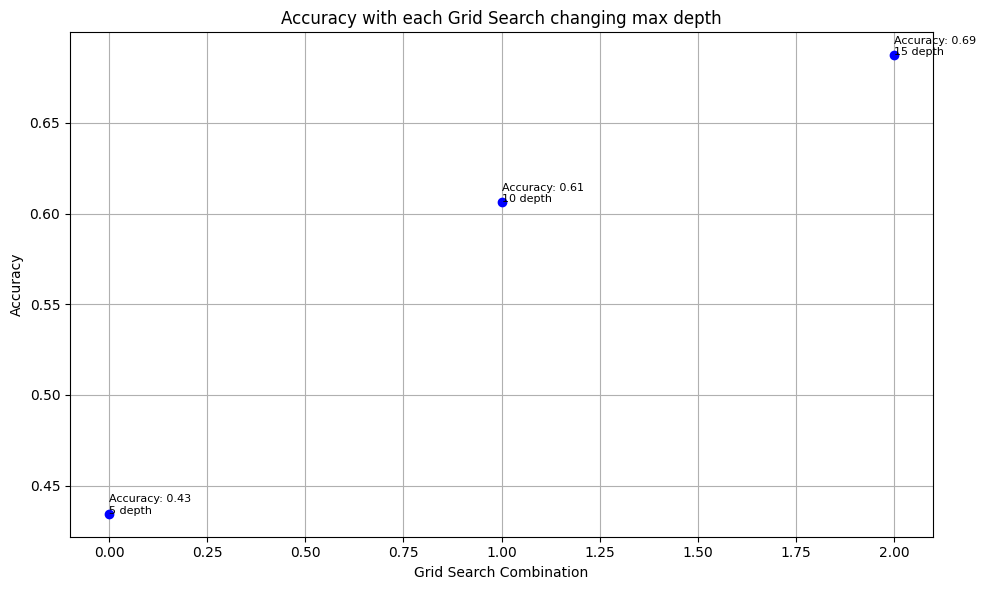

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

param_grid = {
    # 'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15]
}

rfc = RandomForestClassifier(random_state=0)

accuracies_rfc = []
for depth in param_grid['max_depth']:
    # for max_depth in param_grid['max_depth']:
        rfc.set_params(max_depth=depth)
        rfc.fit(XV_train, y_train)
        acc_rfc = rfc.score(XV_test, y_test)
        accuracies_rfc.append(acc_rfc)

accuracies_rfc = np.array(accuracies_rfc)

plt.figure(figsize=(10, 6))
k = 0
for i, max_depth in enumerate(param_grid['max_depth']):
    # for j, max_depth in enumerate(param_grid['max_depth']):
        plt.plot(k, accuracies_rfc[k], 'bo')
        plt.text(k, accuracies_rfc[k], f"Accuracy: {accuracies_rfc[k]:.2f}\n{max_depth} depth ", fontsize=8)
        k += 1

plt.xlabel('Grid Search Combination')
plt.ylabel('Accuracy')
plt.title('Accuracy with each Grid Search changing max depth')

plt.grid(True)
plt.tight_layout()
plt.show()
